# OLS with Gradient Descent

**Prerequisites**

- Tensorflow
- Linear models
- Gradient Descent

**Outcomes**

- Understand how gradient descent can be applied to machine learning models
- See how to use gradient descent to find parameters of OLS model
- Be introduced to `tf.keras` high level API

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
 
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

## Gradient Descent

- First order method for local non-linear optimization
- Given a domain $X \subseteq \mathbb{R}^D$ and a function $f: X \rightarrow \mathbb{R}$
- Iterative updates according to gradient ($\nabla f$) and learning rate ($\alpha$): $$x' = x - \alpha \nabla f(x)$$
- Can be applied for arbitrary non-linear optimization problems 

### Application to ML

- Ingredients to supervised learning:
    1. Cleaned/transformed data $(x_i, y_i)_{i=1}^N$
    2. Choice of model $\hat{y} = f(x; \theta)$
    3. Choice of loss function $\ell(y, \hat{y})$
    4. Strategy/algorithm for updating parameters $\theta$ to minimize $\ell(y, \hat{y})$
- We will use gradient descent as part 4

### Dataset

- We'll use a dataset presented in a [tensorflow tutorial](https://www.tensorflow.org/tutorials/keras/regression) 
- Label: miles per gallon for car
- Features: car/engine characteristics

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy().dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Split and Plot Data

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

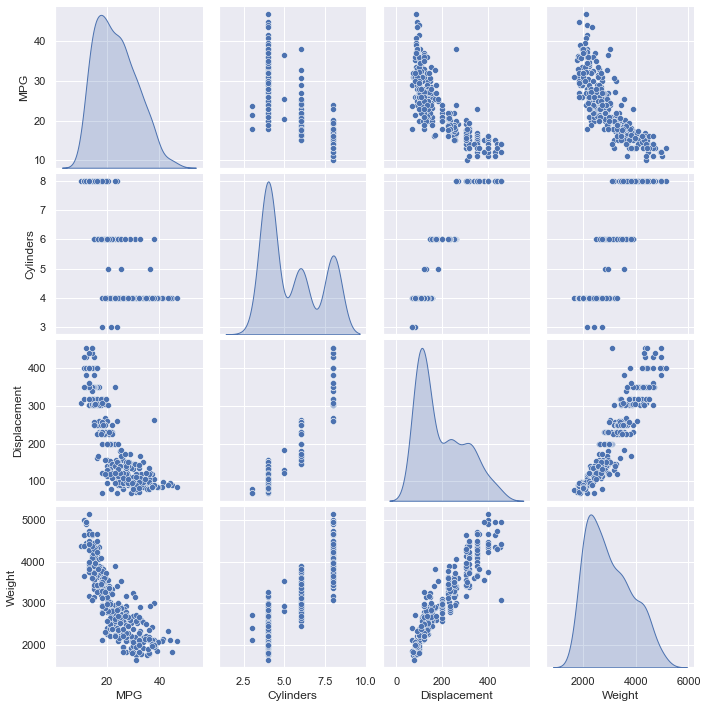

In [6]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

#### Separate Features and Targets

- We'll try to predict MPG using the other features

In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

#### Normalization

- We now need to normalize the features $X$ to have mean 0 std 1
- We'll also convert the targets to `Tensor`s

In [8]:
normalizer = preprocessing.Normalization()
normalizer.adapt(train_features)
X = normalizer(train_features)
X_test = normalizer(test_features)

# convert y 
y = tf.convert_to_tensor(train_labels, dtype="float32")
y_test = tf.convert_to_tensor(test_labels, dtype="float32")

### OLS as Optimization Problem

- Let's use least squares on `df` in order to predict the MPG of a car
- In doing this, we'll transition to a notation used throughout the ML/DL literature
- The model will be: $$\hat{y}_i = W x_i + b$$
    - $W$ is a parameter vector (matrix) called *weights*
    - $b$ is a parameter vector called *bias*
    - $W$ and $b$ together are the parameters we've been calling $\theta$
- Loss function is MSE

### OLS via gradient descent

- We are now ready to apply gradient descent to the OLS model

In [9]:
def grad_desc_tf_ols(X, y, T=200, alpha=0.1):

    # initialize weights and biases
    W = tf.Variable(np.random.randn(X.shape[1]).astype("float32"))
    b = tf.Variable([0.0])

    trace = []
    for i in range(T):
        # compute loss function
        with tf.GradientTape() as tape:
            yhat = tf.linalg.matvec(X, W) + b
            loss = tf.losses.mse(y, yhat)
        
        # compute gradients
        dW, db = tape.gradient(loss, [W, b])
        
        # apply update to each parameter using its gradient
        Wp = W - alpha * dW
        bp = b - alpha * db
        
        # book keeping
        err_theta = max(abs(bp - b), max(abs(Wp - W)))
        err = max(abs(db), max(abs(dW)))
        status = dict(
            i=i,
            loss=loss.numpy(),
            dW=dW.numpy(),
            db=db.numpy(),
            err=err.numpy(),
            err_theta=err_theta.numpy(),
            W=W.numpy(),
            b=b.numpy(),
        )
        trace.append(status)
    
        # update weights and biases for next iteration
        W = tf.Variable(Wp)
        b = tf.Variable(bp)

    return trace

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


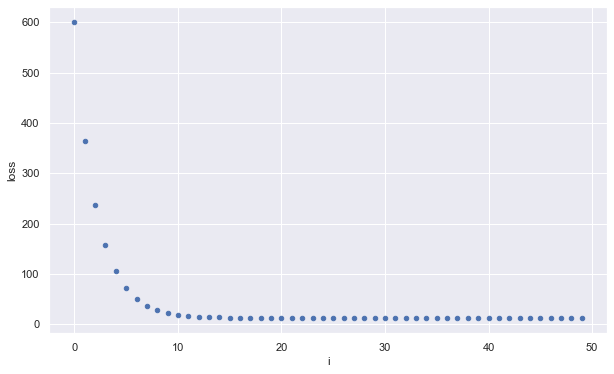

In [10]:
trace = grad_desc_tf_ols(X, y, T=50)
pd.DataFrame(trace).plot.scatter(x="i", y="loss", figsize=(10,6));

## Using Keras

- Above we implemented OLS via gradient descent using lower level tensorflow primitives like `tf.linalg.matvec` and `tf.GradientTape()`
- This allowed us to build up the algorithm from first principles and control all the computations
- Sometimes this level of flexibility is needed, most of the time it isn't
- Tensorflow has a built in high-level API called `keras` that provides common modeling building blocks

### Keras Sequential Models

- sklearn pipelines: data processing + modeling steps $\Rightarrow$ single "model"
- Separates responsibilities:
    - Library (sklearn): apply data transformations, parameters/variables
    - Us: describing data flow and model
- Keras (and its `Sequential` model) plays a similar role for tensorflow

### OLS in Keras

- To see how keras works, we'll replicate our OLS example

#### Model

- Recall we used the OLS model $y = W x + b$
- This is built into keras as the `Dense` layer
- We can combine our `normalizer` and  a `Dense` layer into a `Sequential` model

In [11]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 23
Trainable params: 8
Non-trainable params: 15
_________________________________________________________________


#### Optimizer and Loss

- Optimizer
    - Keras has a number of gradient descent variants in the `tf.keras.optimizers` package 
        - We learn about these variants in SGD video!
    - Can use `tf.keras.optimizers.SGD` for gradient descent
- `.compile`
    - The `.compile` method allows us to specifiy an optimizer and a loss
    - We'll use SGD and MSE

In [12]:
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error' 
)

#### Training

- Now that the model has been compiled (linked to loss and optimizer), we are ready to train
- We use the `.fit` method, which will produce a trace

In [13]:
trace_tf = model.fit(
    train_features, train_labels,
    batch_size=train_features.shape[0],  # for normal gradient descent
    epochs=50,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(test_features, test_labels),
)

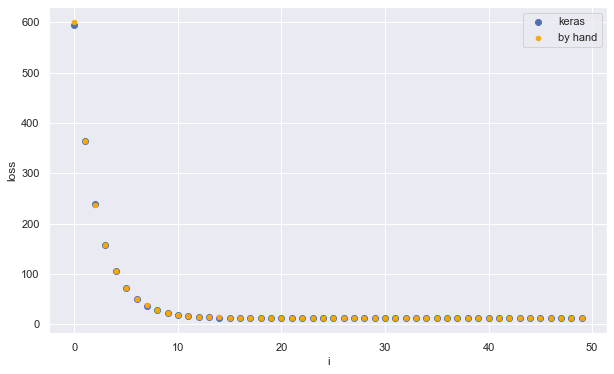

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(len(trace_tf.history["loss"])), trace_tf.history["loss"]);
pd.DataFrame(trace).plot.scatter(x="i", y="loss", ax=ax, c="orange");
ax.legend(["keras", "by hand"]);

#### Review: full code

- The keras version allowed us to abstract away many of the details
- Below we have reproduced all the keras code to see how easy it was:

```python
# define model
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

# compile: link model to loss and optimizer
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error'
)

# fit model
trace_tf = model.fit(
    train_features, train_labels,
    batch_size=train_features.shape[0],  # for normal gradient descent
    epochs=50,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_data=(test_features, test_labels),
)
```

- The benefits we get from using keras will compound as we fit more involved models and/or use more extensive optimization algorithms